## 預測下一個顧客進來要等多久

關於要處理時續性的機器學習問題
使用 RNN 中的 LSTM

- Arrival time : 到達時間
- X1：等待時間
- X2：服務時間
- X3：等待時間＋服務時間＝離開時間

要預測等待時間，可以當作 `預測 X1`。
等待時間與前面的人的服務時間會有直接地影響，故覺得應該只需要保留：
- Arrival time : 到達時間
- X1：等待時間
- X2：服務時間

透過這三個欄位來進行預測！

In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel("./Supplementary DATA on Queues/FIRST BANK (WEEK 1).xlsx", sheet_name="Sheet1")
df = df.iloc[:, :5]

# 移除奇怪的值 => 10,033
df = df.drop(266)
df["Arrival time"] = df["Arrival time"].astype("str").str.replace(".", ":")
df["Arrival time"] = pd.to_datetime(df["Arrival time"], format='%H:%M').dt.strftime("%H:%M")

df = df[['Arrival time', 'X1', 'X2']]

df

/var/folders/vc/svw_78hn1n79nnpst2w2mmyc0000gn/T/ipykernel_3378/1491962889.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df["Arrival time"] = df["Arrival time"].astype("str").str.replace(".", ":")


,Arrival time,X1,X2
0,08:00,11,28
1,08:00,13,25
2,08:00,14,26
3,08:00,9,26
4,08:00,14,23
...,...,...,...
875,14:58,11,23
876,14:59,15,27
877,14:59,14,27
878,14:59,13,29


In [3]:
def time_to_min(time_str):
    h, m = time_str.split(":")
    return int(h) * 60 + int(m)

time_cols = ["Arrival time"]  

for col in time_cols:
    df[col] = df[col].apply(time_to_min)

df

,Arrival time,X1,X2
0,480,11,28
1,480,13,25
2,480,14,26
3,480,9,26
4,480,14,23
...,...,...,...
875,898,11,23
876,899,15,27
877,899,14,27
878,899,13,29


訓練：參考前 20 筆，來預測 後面 5 筆 的等待時間

In [4]:
def normalize(df):
    df_norm = df.copy()
    features = ['Arrival time', 'X1', 'X2']
    # features = ['X1', 'X2']
    df_norm[features] = df_norm[features].apply(lambda x: (x - x.mean()) / (x.max() - x.min())) 
    return df_norm

In [5]:
# 透過前 20筆 的 (Arrival time、X1、X2) 的數據去預測 接下來5筆  的 X1等待時間
# 每筆資料的 input size 是 (seq_length, feature_dim) = (20, 3)

def train_windows(df, the_train=20, the_predict=5):
  X_train, Y_train = [], []
  for i in range(df.shape[0]-the_predict-the_train):
      X_train.append(np.array(df.iloc[i:i+the_train]))
      Y_train.append(np.array(df.iloc[i+the_train:i+the_train+the_predict]["X1"]))
  return np.array(X_train), np.array(Y_train)

In [6]:
def split_data(X,Y,rate):
  X_train = X[int(X.shape[0]*rate):]
  Y_train = Y[int(Y.shape[0]*rate):]
  X_val = X[:int(X.shape[0]*rate)]
  Y_val = Y[:int(Y.shape[0]*rate)]
  return X_train, Y_train, X_val, Y_val

In [7]:
train = df.copy()
train_norm = normalize(train)
X_train, Y_train = train_windows(train_norm, 20, 5)
X_train, Y_train, X_val, Y_val = split_data(X_train, Y_train, 0.1)

In [8]:
train_norm

,Arrival time,X1,X2
0,-0.519418,-0.166667,0.337315
1,-0.519418,0.166667,-0.162685
2,-0.519418,0.333333,0.003982
3,-0.519418,-0.500000,0.003982
4,-0.519418,0.333333,-0.496018
...,...,...,...
875,0.478196,-0.166667,-0.496018
876,0.480582,0.500000,0.170648
877,0.480582,0.333333,0.170648
878,0.480582,0.166667,0.503982


In [9]:
print("X_train", X_train.shape)
print("Y_train", Y_train.shape)
print("X_val", X_val.shape)
print("Y_val", Y_val.shape)

# X_train: (樣本數, 時間步長, 特徵數) -> (769, 20, 3)
# Y_train: (樣本數, 預測長度) -> (769, 5)

X_train (769, 20, 3)
Y_train (769, 5)
X_val (85, 20, 3)
Y_val (85, 5)


In [10]:
model = Sequential()
model.add(LSTM(64, input_shape=(20, 3), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(5, activation='relu'))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17408     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 17733 (69.27 KB)
Trainable params: 17733 (69.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
train = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_val, Y_val))

Epoch 1/50
25/25 [==============================] - 1s 15ms/step - loss: 0.0933 - val_loss: 0.0854
Epoch 2/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0928 - val_loss: 0.0852
Epoch 3/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0928 - val_loss: 0.0854
Epoch 4/50
25/25 [==============================] - 0s 5ms/step - loss: 0.0928 - val_loss: 0.0853
Epoch 5/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0929 - val_loss: 0.0852
Epoch 6/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0928 - val_loss: 0.0856
Epoch 7/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0928 - val_loss: 0.0854
Epoch 8/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0928 - val_loss: 0.0853
Epoch 9/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0927 - val_loss: 0.0853
Epoch 10/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0926 - val_loss: 0.0849
Epoch 11/50
25/25 

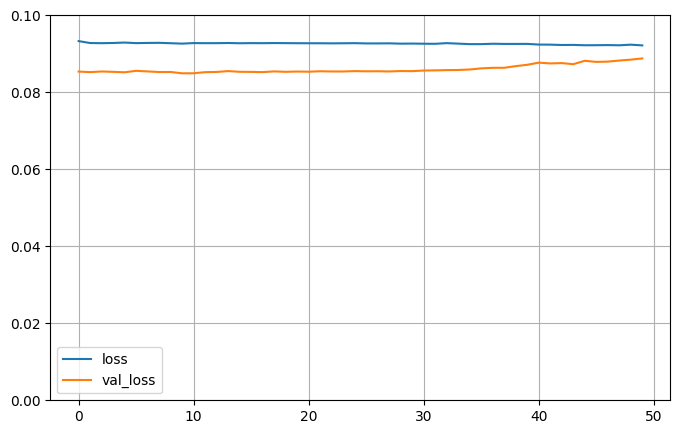

In [12]:
pd.DataFrame(train.history).plot(figsize=(8, 5))
plt.grid(True)
plt.ylim(0, 0.1)
plt.show()

In [13]:
model = Sequential()
model.add(LSTM(64, input_shape=(20, 3), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, input_shape=(20, 3), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(5, activation='relu'))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 20, 64)            17408     
                                                                 
 dropout_1 (Dropout)         (None, 20, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 50757 (198.27 KB)
Trainable params: 50757 (198.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
train = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_val, Y_val))

Epoch 1/50
25/25 [==============================] - 2s 27ms/step - loss: 0.0932 - val_loss: 0.0854
Epoch 2/50
25/25 [==============================] - 0s 9ms/step - loss: 0.0928 - val_loss: 0.0856
Epoch 3/50
25/25 [==============================] - 0s 8ms/step - loss: 0.0928 - val_loss: 0.0856
Epoch 4/50
25/25 [==============================] - 0s 9ms/step - loss: 0.0928 - val_loss: 0.0856
Epoch 5/50
25/25 [==============================] - 0s 9ms/step - loss: 0.0928 - val_loss: 0.0856
Epoch 6/50
25/25 [==============================] - 0s 9ms/step - loss: 0.0928 - val_loss: 0.0856
Epoch 7/50
25/25 [==============================] - 0s 9ms/step - loss: 0.0928 - val_loss: 0.0856
Epoch 8/50
25/25 [==============================] - 0s 9ms/step - loss: 0.0928 - val_loss: 0.0856
Epoch 9/50
25/25 [==============================] - 0s 9ms/step - loss: 0.0928 - val_loss: 0.0856
Epoch 10/50
25/25 [==============================] - 0s 9ms/step - loss: 0.0928 - val_loss: 0.0856
Epoch 11/50
25/25 

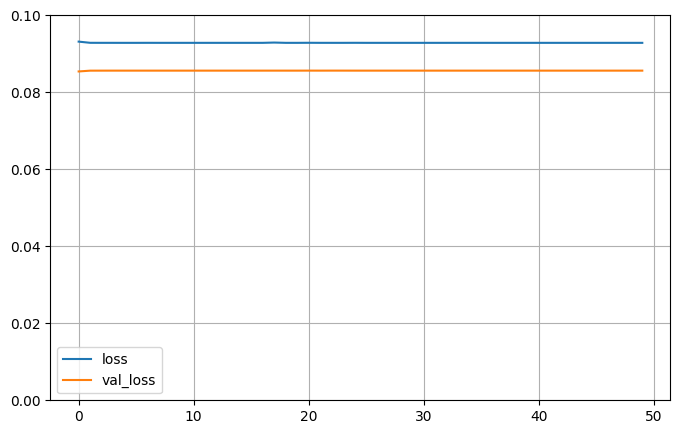

In [15]:
pd.DataFrame(train.history).plot(figsize=(8, 5))
plt.grid(True)
plt.ylim(0, 0.1)
plt.show()

X_train (598, 20, 3)
Y_train (598, 5)
X_val (256, 20, 3)
Y_val (256, 5)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 20, 32)            4608      
                                                                 
 dropout_3 (Dropout)         (None, 20, 32)            0         
                                                                 
 lstm_4 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 165       
                                                                 
Total params: 13093 (51.14 KB)
Trainable params: 13093 (51.14 KB)
Non-trainable params: 0 (0.00 Byte)
____________

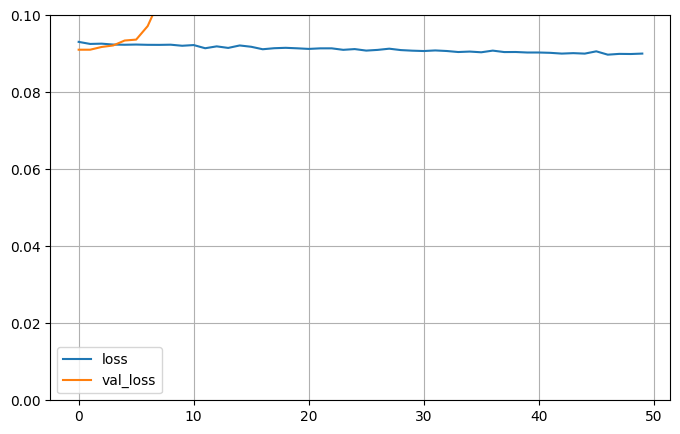

In [16]:
train = df.copy()
train_norm = normalize(train)
X_train, Y_train = train_windows(train_norm, 20, 5)
X_train, Y_train, X_val, Y_val = split_data(X_train, Y_train, 0.3)

print("X_train", X_train.shape)
print("Y_train", Y_train.shape)
print("X_val", X_val.shape)
print("Y_val", Y_val.shape)

model = Sequential()
model.add(LSTM(32, input_shape=(20, 3), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32, input_shape=(20, 3), return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(5, activation='relu'))
model.compile(loss='mse', optimizer='adam')
model.summary()

train = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_val, Y_val))

pd.DataFrame(train.history).plot(figsize=(8, 5))
plt.grid(True)
plt.ylim(0, 0.1)
plt.show()

In [17]:
test_inputs = train_norm.iloc[10:30]  
test_inputs = test_inputs.iloc[:]
test_inputs = test_inputs.values[:].reshape(1, 20, 3)
print(test_inputs)

predictions = model.predict(test_inputs)
df_pred = pd.DataFrame(predictions[0])
df_pred.columns = ["X1"]
print(df_pred)

[[[-0.51703091 -0.16666667  0.33731513]
  [-0.51703091  0.33333333 -0.16268487]
  [-0.51703091  0.          0.33731513]
  [-0.51703091  0.5        -0.32935154]
  [-0.51703091  0.5         0.33731513]
  [-0.51703091  0.5        -0.16268487]
  [-0.51703091  0.16666667 -0.16268487]
  [-0.51703091  0.5         0.33731513]
  [-0.51703091 -0.16666667 -0.32935154]
  [-0.51464427 -0.16666667  0.33731513]
  [-0.51464427 -0.5         0.0039818 ]
  [-0.51225764 -0.5        -0.32935154]
  [-0.51225764  0.         -0.4960182 ]
  [-0.509871   -0.16666667  0.0039818 ]
  [-0.509871   -0.5         0.5039818 ]
  [-0.509871   -0.5         0.0039818 ]
  [-0.509871   -0.33333333  0.33731513]
  [-0.509871    0.33333333  0.33731513]
  [-0.509871    0.33333333 -0.32935154]
  [-0.509871   -0.33333333  0.17064846]]]
1/1 [==============================] - 0s 437ms/step
         X1
0  0.770183
1  0.401052
2  0.237159
3  0.060031
4  0.000000


... 目前不確定哪裡有問題，預計跟著網路上教學做做看使用 LSTM 預測股票的案例，再回頭做這個預測 ～